## TSB-AD Quick Start - Unsupervised Models

### Run Unsupervised AD Model

In this tutorial, we demonstrate how to (i) load a univariate or multivariate time series from the TSB-AD benchmark, (ii) run an unsupervised anomaly detector, and (iii) evaluate its detection quality using standard measures.

Unsupervised models like IForest, LOF, KNN, PCA, etc. do not require training data - they work directly on the entire time series.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from TSB_AD.model_wrapper import run_Unsupervise_AD
from TSB_AD.evaluation.metrics import get_metrics

# Specify Anomaly Detector to use and data directory
AD_Name = 'PCA'   # Can be replaced with: LOF, KNN, PCA, HBOS, COPOD, MatrixProfile, etc.
data_direc = '../Datasets/TSB-AD-U/001_NAB_id_1_Facility_tr_1007_1st_2014.csv'

# Loading Data
df = pd.read_csv(data_direc).dropna()
data = df.iloc[:, 0:-1].values.astype(float)
label = df['Label'].astype(int).to_numpy()

print("Loaded data with shape:", data.shape)
print("Loaded labels with shape:", label.shape)

# Applying Anomaly Detector (Unsupervised - no training data needed)
output = run_Unsupervise_AD(AD_Name, data)

# Evaluation
evaluation_result = get_metrics(output, label)

print("Evaluation results:\n", evaluation_result)

Loaded data with shape: (4031, 1)
Loaded labels with shape: (4031,)
Evaluation results:
 {'AUC-PR': 0.7956508501129314, 'AUC-ROC': 0.9059292449548768, 'VUS-PR': 0.8136138874982192, 'VUS-ROC': 0.9357317496173422, 'Standard-F1': 0.8284740249663477, 'PA-F1': 1.0, 'Event-based-F1': 0.9999999999999996, 'R-based-F1': 0.759779845496952, 'Affiliation-F': 0.996308430785461}
Evaluation results:
 {'AUC-PR': 0.7956508501129314, 'AUC-ROC': 0.9059292449548768, 'VUS-PR': 0.8136138874982192, 'VUS-ROC': 0.9357317496173422, 'Standard-F1': 0.8284740249663477, 'PA-F1': 1.0, 'Event-based-F1': 0.9999999999999996, 'R-based-F1': 0.759779845496952, 'Affiliation-F': 0.996308430785461}


### Plot Time Series with Ground Truth Anomalies

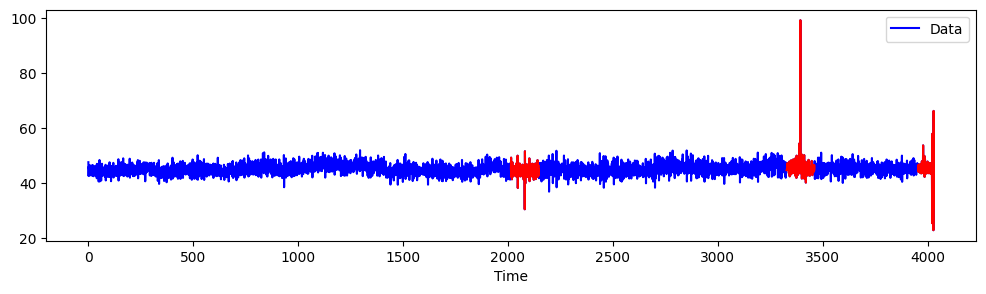

In [3]:
import matplotlib.pyplot as plt
from TSB_AD.evaluation.basic_metrics import basic_metricor

grader = basic_metricor()
range_anomaly = grader.range_convers_new(label)
fig, ax = plt.subplots(figsize=(12, 3))  # Adjust the figure size as needed
ax.plot(range(len(data)), data, color='blue', linewidth=1.5, label='Data')
for r in range_anomaly:
    if r[0] == r[1]:
        ax.plot(r[0], data[r[0]], 'ro', markersize=10)
    else:
        ax.plot(range(r[0], r[1] + 1), data[r[0]:r[1] + 1], color='red', linewidth=1.5) 
plt.legend()
plt.xlabel('Time')
plt.show()

### Plot Model Predictions vs Ground Truth

Now let's visualize what the model actually predicted as anomalies compared to the ground truth.

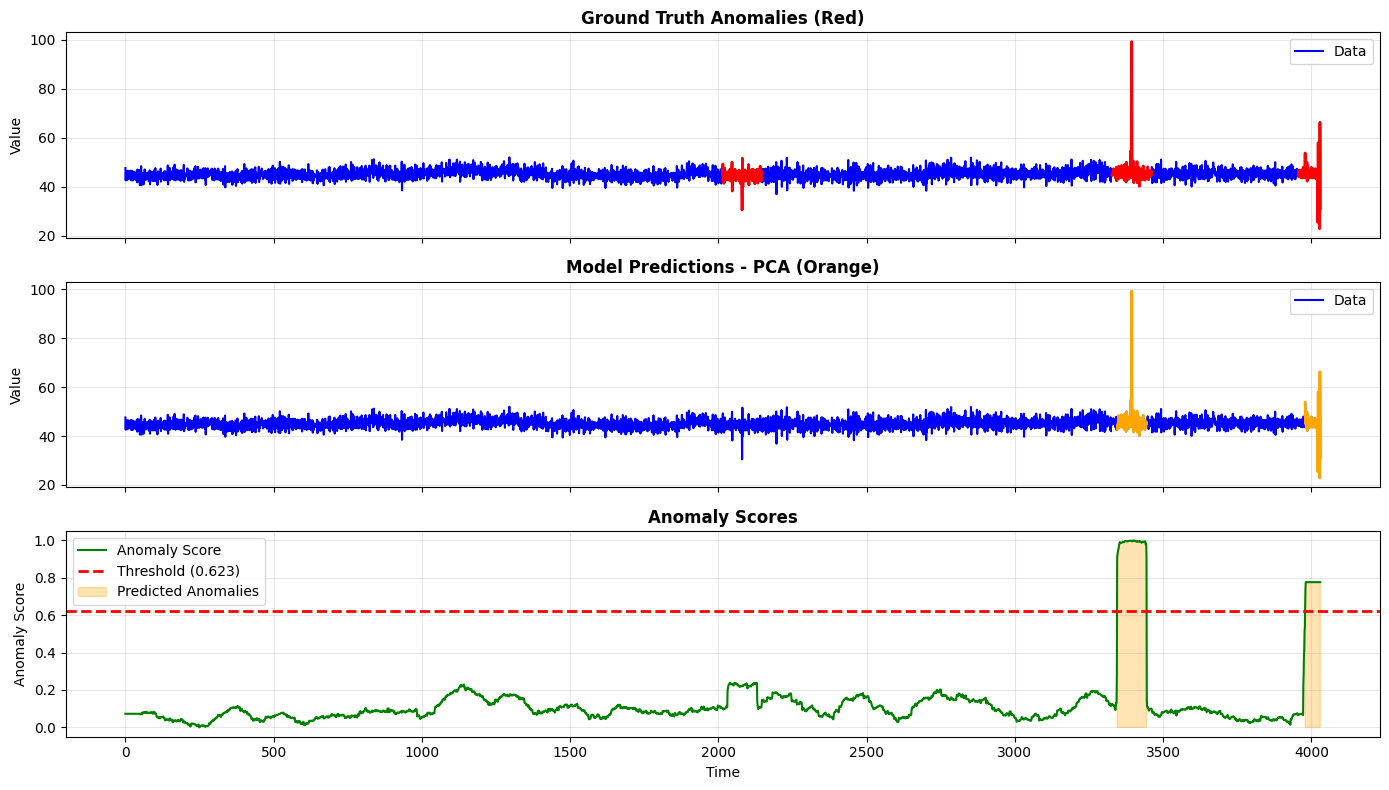


Prediction Summary for PCA:
Total points: 4031
Ground truth anomalies: 343 points (8.51%)
Predicted anomalies: 152 points (3.77%)
Threshold used: 0.6234


In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normalize anomaly scores to 0-1 range
output_normalized = MinMaxScaler(feature_range=(0,1)).fit_transform(output.reshape(-1,1)).ravel()

# Apply threshold to get binary predictions (common: mean + 3*std)
threshold = np.mean(output_normalized) + 3 * np.std(output_normalized)
predictions = (output_normalized > threshold).astype(int)

# Convert predictions to ranges for plotting
pred_range_anomaly = grader.range_convers_new(predictions)

# Create comparison plot
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

# Plot 1: Original data with ground truth anomalies
axes[0].plot(range(len(data)), data, color='blue', linewidth=1.5, label='Data')
for r in range_anomaly:
    if r[0] == r[1]:
        axes[0].plot(r[0], data[r[0]], 'ro', markersize=8)
    else:
        axes[0].plot(range(r[0], r[1] + 1), data[r[0]:r[1] + 1], color='red', linewidth=2) 
axes[0].set_ylabel('Value')
axes[0].set_title('Ground Truth Anomalies (Red)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Original data with model predictions
axes[1].plot(range(len(data)), data, color='blue', linewidth=1.5, label='Data')
for r in pred_range_anomaly:
    if r[0] == r[1]:
        axes[1].plot(r[0], data[r[0]], 'o', color='orange', markersize=8)
    else:
        axes[1].plot(range(r[0], r[1] + 1), data[r[0]:r[1] + 1], color='orange', linewidth=2) 
axes[1].set_ylabel('Value')
axes[1].set_title(f'Model Predictions - {AD_Name} (Orange)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Anomaly scores from the model
axes[2].plot(range(len(output_normalized)), output_normalized, color='green', linewidth=1.5, label='Anomaly Score')
axes[2].axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.3f})')
axes[2].fill_between(range(len(output_normalized)), 0, output_normalized, 
                      where=(output_normalized > threshold), alpha=0.3, color='orange', label='Predicted Anomalies')
axes[2].set_ylabel('Anomaly Score')
axes[2].set_xlabel('Time')
axes[2].set_title('Anomaly Scores', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print(f"Prediction Summary for {AD_Name}:")
print(f"{'='*60}")
print(f"Total points: {len(data)}")
print(f"Ground truth anomalies: {np.sum(label)} points ({100*np.sum(label)/len(label):.2f}%)")
print(f"Predicted anomalies: {np.sum(predictions)} points ({100*np.sum(predictions)/len(predictions):.2f}%)")
print(f"Threshold used: {threshold:.4f}")
print(f"{'='*60}")

### Try Different Unsupervised Models

You can easily test different unsupervised models by changing the `AD_Name` variable. Here are some popular options:

**Statistical Methods:**
- `'IForest'` - Isolation Forest
- `'LOF'` - Local Outlier Factor
- `'KNN'` - K-Nearest Neighbors
- `'PCA'` - Principal Component Analysis
- `'HBOS'` - Histogram-based Outlier Score
- `'COPOD'` - Copula-based Outlier Detection
- `'MatrixProfile'` - Matrix Profile
- `'KShapeAD'` - K-Shape Anomaly Detection
- `'FFT'` - Fast Fourier Transform
- `'SR'` - Spectral Residual

**Foundation Models:**
- `'Lag_Llama'` - Lag-Llama (requires additional setup)
- `'TimesFM'` - TimesFM (requires additional setup)
- `'Chronos'` - Chronos (requires additional setup)
- `'MOMENT_ZS'` - MOMENT Zero-Shot (requires additional setup)

In [5]:
# Example: Compare multiple unsupervised models
import time
import sys
import io
from contextlib import redirect_stdout

models_to_test = ['IForest', 'LOF', 'KNN', 'PCA', 'COPOD']

results = {}
for model_name in models_to_test:
    print(f"\nRunning {model_name}...")
    sys.stdout.flush()
    
    try:
        start_time = time.time()
        
        # Capture any unwanted output from the model
        f = io.StringIO()
        with redirect_stdout(f):
            output = run_Unsupervise_AD(model_name, data)
            evaluation_result = get_metrics(output, label)
        
        elapsed_time = time.time() - start_time
        
        # Store results with timing
        results[model_name] = dict(evaluation_result)  # Make a copy
        results[model_name]['time'] = elapsed_time
        
        # Print available metrics (VUS-PR is the most reliable according to the paper)
        print(f"{model_name} completed in {elapsed_time:.2f}s - VUS-PR: {evaluation_result['VUS-PR']:.4f}")
        sys.stdout.flush()
    except Exception as e:
        print(f"{model_name} failed: {e}")
        sys.stdout.flush()

# Display results summary with available metrics
if results:
    # Get all available metric keys (excluding 'time')
    first_result = list(results.values())[0]
    metric_keys = [k for k in first_result.keys() if k != 'time']
    
    print("\n" + "="*100)
    print("Summary of Results:")
    print("="*100)
    
    # Print header
    header = f"{'Model':<15}"
    for key in metric_keys:
        header += f" {key:<12}"
    header += f" {'Time(s)':<10}"
    print(header)
    print("="*100)
    
    # Print results
    for model_name, result in results.items():
        row = f"{model_name:<15}"
        for key in metric_keys:
            row += f" {result[key]:<12.4f}"
        row += f" {result['time']:<10.2f}"
        print(row)
    print("="*100)
    
    # Highlight best performer by VUS-PR
    best_model = max(results.items(), key=lambda x: x[1]['VUS-PR'])
    print(f"\n🏆 Best model by VUS-PR: {best_model[0]} ({best_model[1]['VUS-PR']:.4f})")
else:
    print("No results to display.")


Running IForest...
IForest completed in 4.82s - VUS-PR: 0.1847

Running LOF...
IForest completed in 4.82s - VUS-PR: 0.1847

Running LOF...
LOF completed in 2.28s - VUS-PR: 0.1647

Running KNN...
LOF completed in 2.28s - VUS-PR: 0.1647

Running KNN...
KNN completed in 2.38s - VUS-PR: 0.1114

Running PCA...
KNN completed in 2.38s - VUS-PR: 0.1114

Running PCA...
PCA completed in 2.70s - VUS-PR: 0.8136

Running COPOD...
PCA completed in 2.70s - VUS-PR: 0.8136

Running COPOD...
COPOD completed in 5.06s - VUS-PR: 0.1114

Summary of Results:
Model           AUC-PR       AUC-ROC      VUS-PR       VUS-ROC      Standard-F1  PA-F1        Event-based-F1 R-based-F1   Affiliation-F Time(s)   
IForest         0.1527       0.6811       0.1847       0.7529       0.2641       0.8543       0.3701       0.1970       0.8233       4.82      
LOF             0.1406       0.5116       0.1647       0.5992       0.1585       1.0000       1.0000       0.3609       0.9685       2.28      
KNN             0.0851

### Visualize Model Performance Comparison

Now let's create visual comparisons of the models across different metrics.

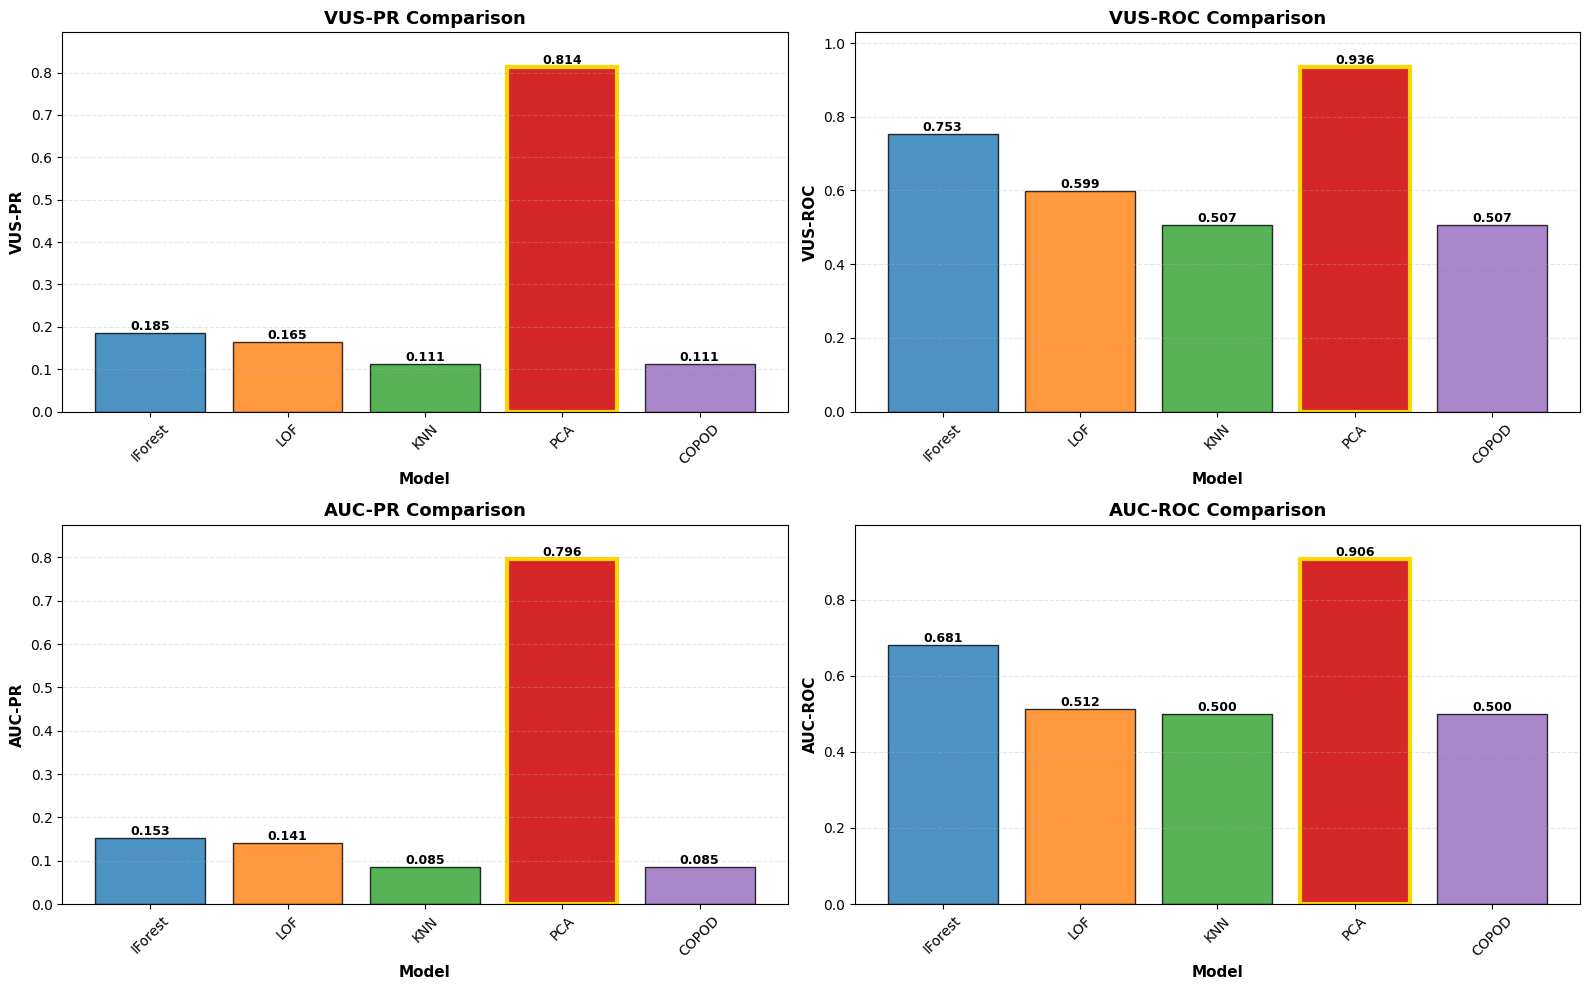

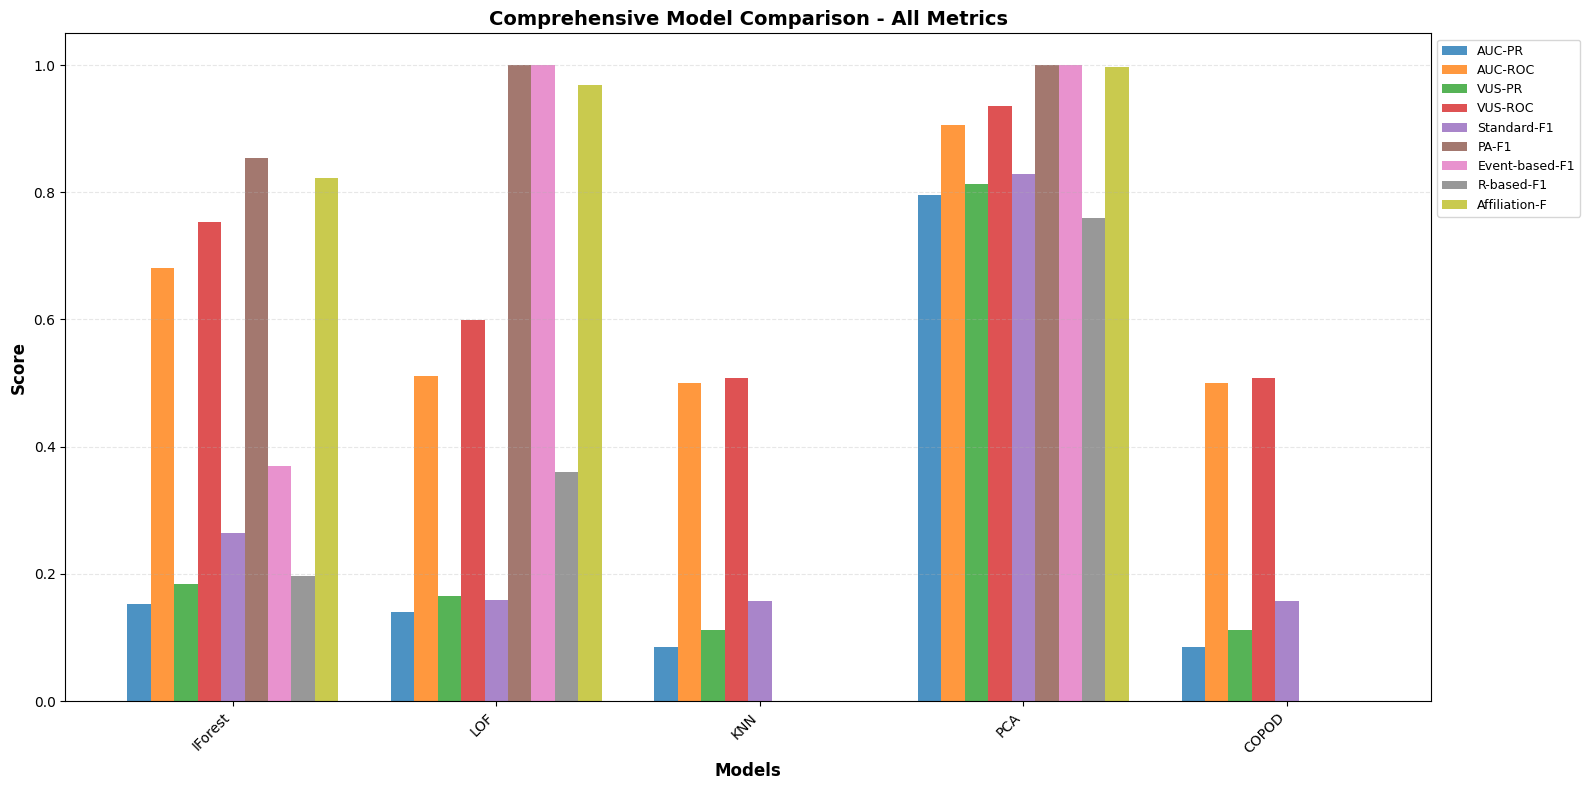

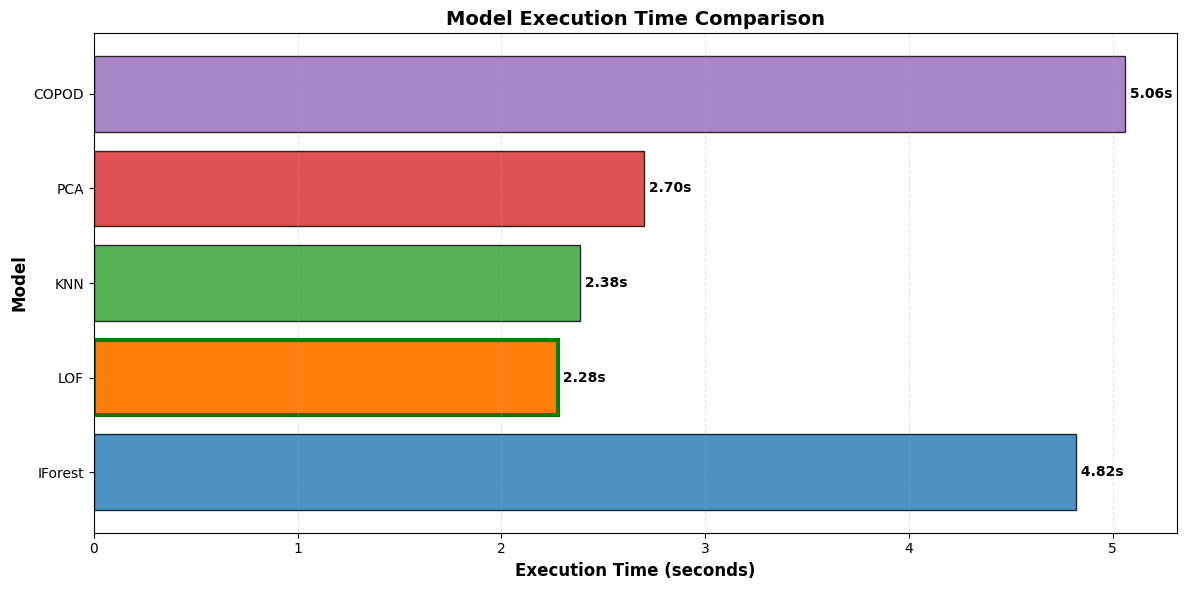


✨ Visualization complete!
📊 Best model by VUS-PR: PCA
⚡ Fastest model: LOF


In [6]:
if results:
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Prepare data
    model_names = list(results.keys())
    metric_keys = [k for k in results[model_names[0]].keys() if k != 'time']
    
    # Key metrics to visualize (most important ones)
    key_metrics = ['VUS-PR', 'VUS-ROC', 'AUC-PR', 'AUC-ROC']
    available_key_metrics = [m for m in key_metrics if m in metric_keys]
    
    # Create subplots for key metrics
    n_key_metrics = len(available_key_metrics)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.ravel()
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for idx, metric in enumerate(available_key_metrics):
        values = [results[model][metric] for model in model_names]
        bars = axes[idx].bar(model_names, values, color=colors[:len(model_names)], alpha=0.8, edgecolor='black')
        
        # Highlight the best model
        best_idx = np.argmax(values)
        bars[best_idx].set_alpha(1.0)
        bars[best_idx].set_edgecolor('gold')
        bars[best_idx].set_linewidth(3)
        
        axes[idx].set_xlabel('Model', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel(metric, fontsize=11, fontweight='bold')
        axes[idx].set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
        axes[idx].grid(axis='y', alpha=0.3, linestyle='--')
        axes[idx].set_ylim([0, max(values) * 1.1])
        
        # Add value labels on bars
        for i, (bar, val) in enumerate(zip(bars, values)):
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                          f'{val:.3f}',
                          ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # Rotate x-axis labels
        axes[idx].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Create a comprehensive comparison plot for all metrics
    fig, ax = plt.subplots(figsize=(16, 8))
    
    x = np.arange(len(model_names))
    width = 0.8 / len(metric_keys)  # Width of bars
    
    for idx, metric in enumerate(metric_keys):
        values = [results[model][metric] for model in model_names]
        offset = (idx - len(metric_keys)/2) * width + width/2
        ax.bar(x + offset, values, width, label=metric, alpha=0.8)
    
    ax.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Comprehensive Model Comparison - All Metrics', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Execution time comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    times = [results[model]['time'] for model in model_names]
    bars = ax.barh(model_names, times, color=colors[:len(model_names)], alpha=0.8, edgecolor='black')
    
    # Highlight fastest model
    fastest_idx = np.argmin(times)
    bars[fastest_idx].set_alpha(1.0)
    bars[fastest_idx].set_edgecolor('green')
    bars[fastest_idx].set_linewidth(3)
    
    ax.set_xlabel('Execution Time (seconds)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Model', fontsize=12, fontweight='bold')
    ax.set_title('Model Execution Time Comparison', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, (bar, time) in enumerate(zip(bars, times)):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
               f' {time:.2f}s',
               ha='left', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✨ Visualization complete!")
    print(f"📊 Best model by VUS-PR: {max(results.items(), key=lambda x: x[1]['VUS-PR'])[0]}")
    print(f"⚡ Fastest model: {min(results.items(), key=lambda x: x[1]['time'])[0]}")
else:
    print("No results to visualize. Run the comparison cell first.")

### ROC and Precision-Recall Curves

Now let's plot the proper AUC curves (ROC and PR curves) as seen in academic papers.

Computing scores for IForest...
Computing scores for LOF...
Computing scores for KNN...
Computing scores for PCA...
Computing scores for LOF...
Computing scores for KNN...
Computing scores for PCA...
Computing scores for COPOD...

Plotting ROC curves...
Plotting Precision-Recall curves...
Computing scores for COPOD...

Plotting ROC curves...
Plotting Precision-Recall curves...


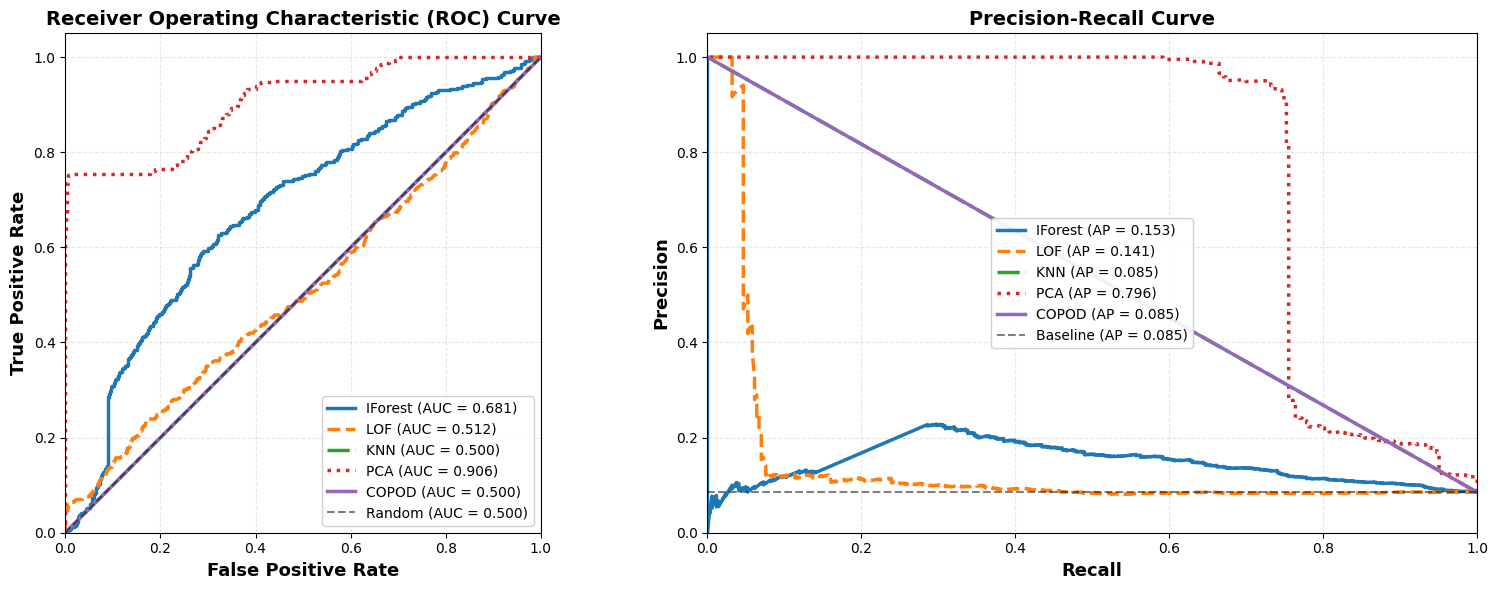


📈 AUC Curve Analysis Complete!
📊 ROC-AUC: Measures overall discriminative ability across all thresholds
📊 PR-AUC: Focuses on performance on the positive (anomaly) class


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import io
from contextlib import redirect_stdout

# Get anomaly scores for all models
model_scores = {}
for model_name in ['IForest', 'LOF', 'KNN', 'PCA', 'COPOD']:
    print(f"Computing scores for {model_name}...")
    try:
        # Capture output to avoid duplicates
        f = io.StringIO()
        with redirect_stdout(f):
            score = run_Unsupervise_AD(model_name, data)
        
        # Normalize scores to 0-1 range
        from sklearn.preprocessing import MinMaxScaler
        score_normalized = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
        model_scores[model_name] = score_normalized
    except Exception as e:
        print(f"Failed to get scores for {model_name}: {e}")

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = {'IForest': '#1f77b4', 'LOF': '#ff7f0e', 'KNN': '#2ca02c', 'PCA': '#d62728', 'COPOD': '#9467bd'}
linestyles = {'IForest': '-', 'LOF': '--', 'KNN': '-.', 'PCA': ':', 'COPOD': '-'}

# Plot 1: ROC Curve
print("\nPlotting ROC curves...")
for model_name, scores in model_scores.items():
    fpr, tpr, _ = roc_curve(label, scores)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color=colors[model_name], linestyle=linestyles[model_name],
             linewidth=2.5, label=f'{model_name} (AUC = {roc_auc:.3f})')

# Add diagonal reference line
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random (AUC = 0.500)')

ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_aspect('equal')

# Plot 2: Precision-Recall Curve
print("Plotting Precision-Recall curves...")
for model_name, scores in model_scores.items():
    precision, recall, _ = precision_recall_curve(label, scores)
    avg_precision = average_precision_score(label, scores)
    
    ax2.plot(recall, precision, color=colors[model_name], linestyle=linestyles[model_name],
             linewidth=2.5, label=f'{model_name} (AP = {avg_precision:.3f})')

# Add baseline (proportion of positive class)
baseline = np.sum(label) / len(label)
ax2.plot([0, 1], [baseline, baseline], 'k--', linewidth=1.5, alpha=0.5, 
         label=f'Baseline (AP = {baseline:.3f})')

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall', fontsize=13, fontweight='bold')
ax2.set_ylabel('Precision', fontsize=13, fontweight='bold')
ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()1

print("\n" + "="*70)
print("📈 AUC Curve Analysis Complete!")
print("="*70)
print("📊 ROC-AUC: Measures overall discriminative ability across all thresholds")
print("📊 PR-AUC: Focuses on performance on the positive (anomaly) class")
print("="*70)

### Volume Under Surface (VUS) - 3D Visualization

VUS extends traditional AUC by evaluating performance across multiple sliding window sizes, creating a 3D surface. This is the metric used in the TSB-AD paper.

### Understanding the VUS-PR 3D Plot

**What the "triangle" shape means:**

The triangular shape you see is actually a **fundamental property of precision-recall relationships** and tells us important things about model performance:

1. **Why it's triangular:**
   - At low recall (left side of X-axis), precision can be very high - the model is being very conservative
   - As recall increases (moving right on X-axis), precision typically decreases - the model becomes more aggressive
   - This creates the characteristic "triangle" or "surface" shape

2. **What to look for:**
   - **Height (Z-axis):** Higher precision values = better quality detections
   - **Width (X-axis):** How far the model extends along recall = detection coverage
   - **Volume:** Larger volume under the surface = better overall performance across all window sizes
   - **Color gradient (Y-axis):** Shows how performance changes with different temporal scales (window sizes)

3. **Ideal vs. Real:**
   - An **ideal model** would have a rectangular surface at Z=1.0 (perfect precision and recall)
   - **Real models** show the trade-off: high precision at low recall, or high recall at lower precision
   - The **larger the triangular volume**, the better the model balances this trade-off

4. **In your plot:**
   - If the triangle stays **near the top (Z≈1.0)**, your model maintains high precision even at high recall → Excellent!
   - If the triangle **drops quickly** as recall increases, the model makes many false positives → Needs improvement
   - If the **colors are consistent**, performance is stable across different window sizes → Robust!

**Below we'll add reference planes to make this even more interpretable.**

In [8]:
from TSB_AD.evaluation.metrics import generate_curve
import numpy as np
import io
from contextlib import redirect_stdout
from sklearn.preprocessing import MinMaxScaler

# Select one model to visualize
selected_model = 'LOF'  # Can be changed to any model: 'PCA', 'LOF', 'KNN', 'COPOD', etc.

print(f"Computing VUS 3D surface for {selected_model}...")

# Get anomaly scores
f = io.StringIO()
with redirect_stdout(f):
    score = run_Unsupervise_AD(selected_model, data)

score_normalized = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

# Configure sliding window size (controls how many window sizes are tested)
# Options: 20 (fast), 50 (balanced), 100 (comprehensive, slower)
slidingWindow = 100

# Generate VUS curves
fpr_curve, window_sizes_roc, tpr_curve, tpr_curve_pr, precision_curve, window_sizes_pr, avg_auc, avg_ap = generate_curve(
    label, score_normalized, slidingWindow
)

print(f"VUS-ROC: {avg_auc:.4f}")
print(f"VUS-PR: {avg_ap:.4f}")

# Create INTERACTIVE 3D plot with reference planes
try:
    import plotly.graph_objects as go
    
    # Create single 3D plot for VUS-PR
    fig = go.Figure()
    
    # Add the main VUS-PR 3D Surface (Recall vs Window Size vs Precision)
    # The connecting line shows the trajectory of performance as window size increases
    fig.add_trace(
        go.Scatter3d(
            x=tpr_curve_pr,
            y=window_sizes_pr,
            z=precision_curve,
            mode='lines+markers',  # LINE: shows performance trajectory across window sizes
            line=dict(color='green', width=3),
            marker=dict(
                size=5,
                color=window_sizes_pr,
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title="Window<br>Size", len=0.7, x=1.15)
            ),
            name=selected_model,
            showlegend=True,
            hovertemplate='<b>Recall:</b> %{x:.3f}<br><b>Window Size:</b> %{y:.0f}<br><b>Precision:</b> %{z:.3f}<extra></extra>'
        )
    )
    
    # Add reference plane at Precision = 0.5 (baseline)
    recall_grid = np.linspace(0, 1, 10)
    window_grid = np.linspace(0, max(window_sizes_pr), 10)
    recall_mesh, window_mesh = np.meshgrid(recall_grid, window_grid)
    
    fig.add_trace(
        go.Surface(
            x=recall_mesh,
            y=window_mesh,
            z=np.ones_like(recall_mesh) * 0.5,
            opacity=0.2,
            colorscale=[[0, 'red'], [1, 'red']],
            showscale=False,
            name='Baseline (0.5)',
            hovertemplate='Baseline: Precision=0.5<extra></extra>'
        )
    )
    
    # Add reference plane at Precision = 0.8 (good performance threshold)
    fig.add_trace(
        go.Surface(
            x=recall_mesh,
            y=window_mesh,
            z=np.ones_like(recall_mesh) * 0.8,
            opacity=0.15,
            colorscale=[[0, 'orange'], [1, 'orange']],
            showscale=False,
            name='Good (0.8)',
            hovertemplate='Good performance: Precision=0.8<extra></extra>'
        )
    )
    
    # Add "floor" projection to show the recall range
    fig.add_trace(
        go.Scatter3d(
            x=tpr_curve_pr,
            y=window_sizes_pr,
            z=np.zeros_like(precision_curve),
            mode='lines',
            line=dict(color='gray', width=2, dash='dot'),
            opacity=0.3,
            name='Projection',
            showlegend=False,
            hoverinfo='skip'
        )
    )
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=f'<b>VUS-PR: {selected_model}</b><br>Volume Score = {avg_ap:.4f}<br><sub>Larger volume = Better performance (tested {slidingWindow} window sizes)</sub>',
            x=0.5,
            xanchor='center',
            font=dict(size=16)
        ),
        scene=dict(
            xaxis_title=dict(text='Recall (TPR)<br><sub>How many anomalies detected</sub>', font=dict(size=12, family='Arial', color='black')),
            yaxis_title=dict(text='Sliding Window Size<br><sub>Temporal scale</sub>', font=dict(size=12, family='Arial', color='black')),
            zaxis_title=dict(text='Precision<br><sub>Detection quality</sub>', font=dict(size=12, family='Arial', color='black')),
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.3)
            ),
            xaxis=dict(range=[0, 1]),
            yaxis=dict(range=[0, max(window_sizes_pr)]),
            zaxis=dict(range=[0, 1])
        ),
        height=700,
        width=1100,
        showlegend=True,
        legend=dict(x=0.02, y=0.98, font=dict(size=11), bgcolor='rgba(255,255,255,0.8)'),
        margin=dict(l=0, r=150, t=120, b=0)
    )
    
    # Show the interactive plot
    fig.show()
    
    print(f"\nModel: {selected_model} | VUS-PR: {avg_ap:.4f} | Window sizes: 1-{slidingWindow}")
    print(f"\nGreen line explanation:")
    print(f"The line traces the model's performance trajectory as the sliding window size")
    print(f"increases from 1 to {slidingWindow}. Each point on the line represents:")
    print(f"  - X-axis (Recall): How many anomalies are detected at this window size")
    print(f"  - Y-axis (Window): The current window size being evaluated")
    print(f"  - Z-axis (Precision): Detection quality at this window size")
    print(f"\nThe line shows how precision/recall trade-off changes with temporal scale.")
    
except ImportError:
    print("\nPlotly not installed. Falling back to matplotlib...")
    print("To enable interactive plots: pip install plotly")
    
    # Fallback to matplotlib - VUS-PR only
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot main curve
    ax.plot(tpr_curve_pr, window_sizes_pr, precision_curve, 
             color='#2ca02c', linewidth=3, alpha=0.9, label=f'{selected_model}', zorder=10)
    ax.scatter(tpr_curve_pr, window_sizes_pr, precision_curve, 
               c=window_sizes_pr, cmap='viridis', s=20, alpha=0.6, zorder=10)
    
    # Add reference planes
    recall_grid = np.linspace(0, 1, 10)
    window_grid = np.linspace(0, max(window_sizes_pr), 10)
    recall_mesh, window_mesh = np.meshgrid(recall_grid, window_grid)
    
    # Baseline plane at 0.5
    ax.plot_surface(recall_mesh, window_mesh, np.ones_like(recall_mesh) * 0.5,
                    alpha=0.1, color='red', label='Baseline (0.5)')
    
    # Good performance plane at 0.8
    ax.plot_surface(recall_mesh, window_mesh, np.ones_like(recall_mesh) * 0.8,
                    alpha=0.1, color='orange', label='Good (0.8)')
    
    # Floor projection
    ax.plot(tpr_curve_pr, window_sizes_pr, np.zeros_like(precision_curve),
            'gray', linestyle='--', linewidth=1, alpha=0.4, label='Projection')
    
    ax.set_xlabel('Recall (TPR)\n[Coverage]', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_ylabel('Sliding Window Size\n[Temporal Scale]', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_zlabel('Precision\n[Quality]', fontsize=12, fontweight='bold', labelpad=10)
    ax.set_title(f'VUS-PR: {selected_model}\nVolume = {avg_ap:.4f}\nAvg Precision = {np.mean(precision_curve):.3f}', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.view_init(elev=20, azim=45)
    ax.set_zlim([0, 1])
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nModel: {selected_model} | VUS-PR: {avg_ap:.4f} | Avg Precision: {np.mean(precision_curve):.3f} | Window sizes: 1-{slidingWindow}")
    print(f"\nGreen line explanation:")
    print(f"The line traces the model's performance trajectory as the sliding window size")
    print(f"increases from 1 to {slidingWindow}. It shows how the precision/recall trade-off")
    print(f"evolves across different temporal scales.")


Computing VUS 3D surface for LOF...
VUS-ROC: 0.5991
VUS-PR: 0.1647
VUS-ROC: 0.5991
VUS-PR: 0.1647



Model: LOF | VUS-PR: 0.1647 | Window sizes: 1-100

Green line explanation:
The line traces the model's performance trajectory as the sliding window size
increases from 1 to 100. Each point on the line represents:
  - X-axis (Recall): How many anomalies are detected at this window size
  - Y-axis (Window): The current window size being evaluated
  - Z-axis (Precision): Detection quality at this window size

The line shows how precision/recall trade-off changes with temporal scale.
